In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    full_train_data=None
    for i in range(10):
        if i==0:
            a=mat['train'+str(i)].shape[0]
            new_col=np.array([i]*a).reshape(a,1)
            new=np.append(mat['train'+str(i)],new_col,axis=1)
            full_train_data=new
        else:
            a=mat['train'+str(i)].shape[0]
            new_col=np.array([i]*a).reshape(a,1)
            new_=np.append(mat['train'+str(i)],new_col,axis=1)
            full_train_data=np.vstack((full_train_data,new_))

    #Test Data
    full_test_data=None
    for i in range(10):
        if i==0:
            a=mat['test'+str(i)].shape[0]
            new_col=np.array([i]*a).reshape(a,1)
            new=np.append(mat['test'+str(i)],new_col,axis=1)
            full_test_data=new
        else:
            a=mat['test'+str(i)].shape[0]
            new_col=np.array([i]*a).reshape(a,1)
            new_=np.append(mat['test'+str(i)],new_col,axis=1)
            full_test_data=np.vstack((full_test_data,new_))
            
    #Feature Selection
    train_data=full_train_data[:,0:784]
    test_data=full_test_data[:,0:784]

    train_label=full_train_data[:,784:785].reshape(train_data.shape[0],1)
    test_label=full_test_data[:,784:785].reshape(test_data.shape[0],1)

    a = range(train_data.shape[0])

    aperm = np.random.permutation(a)

    validation_data = train_data[aperm[0:10000],:]
    validation_label=train_label[aperm[0:10000],:].reshape(validation_data.shape[0],1)

    train_data = train_data[aperm[10000:],:]
    train_label=train_label[aperm[10000:],:]

    
    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0
    print("done")
    return train_data, train_label, validation_data, validation_label, test_data, test_label


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))
    
    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    train_data=np.column_stack((np.ones(train_data.shape[0]),train_data))
    
    theta=sigmoid(np.dot(initialWeights.reshape(train_data.shape[1],),train_data.transpose()))
        
    theta=theta.reshape(train_data.shape[0],1)
    
    error= -(np.sum(labeli*np.log(theta)+(1-labeli)*np.log(1-theta)))/train_data.shape[0]
    #for i in range(train_data.shape[1]):
        #error_grad[i,:]=(np.dot((theta[i,:]-labeli[i,:]),train_data[i,:].reshape(train_data.shape[0],1).transpose()))/train_data.shape[0]
    
    error_grad=(np.sum(np.dot((theta.reshape(train_data.shape[0],)-labeli.reshape(train_data.shape[0],)).transpose(),train_data).reshape(train_data.shape[1],1),axis=1))/train_data.shape[0]
    
    #print(error_grad)
    #print(error_grad.shape)
    
    return error, error_grad


def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    data=np.column_stack((np.ones(data.shape[0]),data))
    n_class=W.shape[1]
    
    scores=np.zeros((n_class,data.shape[0]))
    
    for i in range(n_class):
        scores[i,:]=sigmoid(np.dot(data,W[:,i]))
    
    scores=scores.reshape(n_class,data.shape[0])

    label=np.argmax(scores.transpose(),axis=1)
    
    label=label.reshape(data.shape[0],1)
    
    return label


def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector of size (D + 1) x 1
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    train_data, Y = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    initialWeights_b=params.reshape(716,10)
    
    #error_grad = 0
    #error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    train_data=np.column_stack((np.ones(train_data.shape[0]),train_data))
    
    a=np.exp(np.dot(train_data,initialWeights_b))
        
    b=np.sum(a,axis=1)
    b=b.reshape(b.shape[0],1)
    
    theta=a/b
    
    #print(theta.shape)
    error= - (np.sum(np.sum(Y*np.log(theta))))
    
    #print(error)
    #error_grad= np.sum(np.dot((theta.transpose()-Y),train_data.transpose()),axis=1)
    #for i in range(train_data.shape[1]):
        #error_grad[i,:] = np.sum(np.dot((theta-Y).transpose(),train_data[:,i].transpose()),axis=0)
    
    error_grad = np.dot(train_data.transpose(),(theta-Y))
    
    error_grad=error_grad.ravel()
    
    return error, error_grad


def mlrPredict(W_b, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    #label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    data=np.column_stack((np.ones(data.shape[0]),data))
    
    #scores=np.zeros((n_class,data.shape[0]))
    
    #for i in range(n_class):
        #scores[i,:]=np.where(sigmoid(np.dot(data,W_b[:,i]))>=0.5,1,0)
    
    #scores=scores.reshape(n_class,data.shape[0])
    
    a=np.dot(data,W_b)
    
    a=np.exp(a)
    
    b=np.sum(a,axis=1)
    
    b=b.reshape(b.shape[0],1)
    
    theta=a/b
    
    label=np.argmax(theta,axis=1)
    
    label=label.reshape(data.shape[0],1)
    
    return label

"""
Script for Logistic Regression
"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}
for i in range(n_class):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))


# Find the accuracy on Training Dataset
predicted_label_train = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_train == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_test = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_test == test_label).astype(float))) + '%')

#print(time()-a)

"""
Script for Support Vector Machine
"""

print('\n\n--------------SVM-------------------\n\n')
##################
# YOUR CODE HERE #
##################


"""
Script for Extra Credit Part
"""
# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class)).reshape(n_feature + 1, n_class)
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))


# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label.reshape(train_label.shape[0],1)).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label.reshape(validation_label.shape[0],1)).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label.reshape(test_label.shape[0],1)).astype(float))) + '%')


done

 Training set Accuracy:92.67999999999999%

 Validation set Accuracy:91.49000000000001%

 Testing set Accuracy:91.85%


--------------SVM-------------------



 Training set Accuracy:93.156%

 Validation set Accuracy:92.49000000000001%

 Testing set Accuracy:92.51%


In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
train_cf=metrics.confusion_matrix(train_label,predicted_label_train)
test_cf=metrics.confusion_matrix(test_label,predicted_label_test)

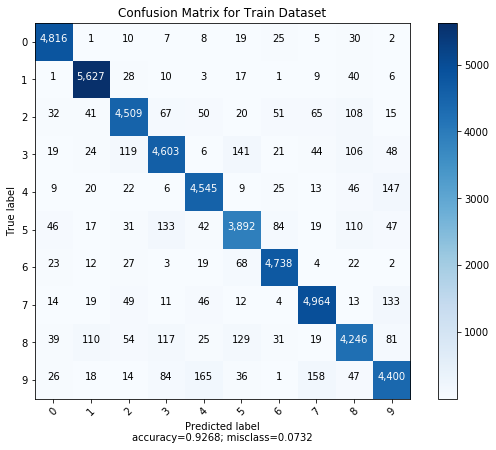

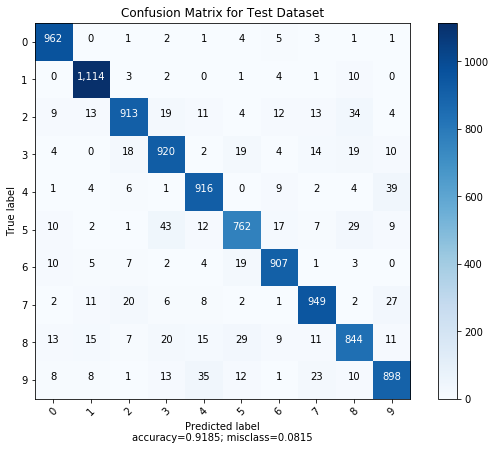

In [7]:
plot_confusion_matrix(cm=train_cf,normalize=False,target_names=['0','1','2','3','4','5','6','7','8','9'],title="Confusion Matrix for Train Dataset")
plot_confusion_matrix(cm=test_cf,normalize=False,target_names=['0','1','2','3','4','5','6','7','8','9'],title="Confusion Matrix for Test Dataset")


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    import itertools
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)



def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():
    sampleClassificationReport = metrics.classification_report(predicted_label_test,test_label)
    plot_classification_report(sampleClassificationReport)
    plt.savefig('BLR_test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()
    
main()

[0.98, 0.94, 0.96]
[0.98, 0.95, 0.97]
[0.88, 0.93, 0.91]
[0.91, 0.89, 0.9]
[0.93, 0.91, 0.92]
[0.85, 0.89, 0.87]
[0.95, 0.94, 0.94]
[0.92, 0.93, 0.92]
[0.87, 0.88, 0.87]
[0.89, 0.9, 0.89]
plotMat: [[0.98, 0.94, 0.96], [0.98, 0.95, 0.97], [0.88, 0.93, 0.91], [0.91, 0.89, 0.9], [0.93, 0.91, 0.92], [0.85, 0.89, 0.87], [0.95, 0.94, 0.94], [0.92, 0.93, 0.92], [0.87, 0.88, 0.87], [0.89, 0.9, 0.89]]
support: [1019, 1172, 977, 1028, 1004, 852, 969, 1024, 956, 999]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    import itertools
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)



def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():
    sampleClassificationReport = metrics.classification_report(predicted_label_train,train_label)
    plot_classification_report(sampleClassificationReport)
    plt.savefig('BLR_train_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()
main()

[0.98, 0.96, 0.97]
[0.98, 0.96, 0.97]
[0.91, 0.93, 0.92]
[0.9, 0.91, 0.91]
[0.94, 0.93, 0.93]
[0.88, 0.9, 0.89]
[0.96, 0.95, 0.96]
[0.94, 0.94, 0.94]
[0.88, 0.89, 0.88]
[0.89, 0.9, 0.9]
plotMat: [[0.98, 0.96, 0.97], [0.98, 0.96, 0.97], [0.91, 0.93, 0.92], [0.9, 0.91, 0.91], [0.94, 0.93, 0.93], [0.88, 0.9, 0.89], [0.96, 0.95, 0.96], [0.94, 0.94, 0.94], [0.88, 0.89, 0.88], [0.89, 0.9, 0.9]]
support: [5025, 5889, 4863, 5041, 4909, 4343, 4981, 5300, 4768, 4881]
